Imports + 版本检查

In [1]:
import torch, torch.nn.functional as F
import torch_geometric
print(torch.__version__, torch_geometric.__version__)


d:\anaconda3\envs\gnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.8.0+cpu 2.7.0


加载数据

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root=r"C:\Users\Administrator\Desktop\GNNmodel\data\Planetoid", name="Cora", transform=NormalizeFeatures())
data = dataset[0]


定义模型（GCN）

In [5]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn. Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 =GCNConv(dataset.num_features, hidden_channels)#1433,16
        self.conv2 =GCNConv(hidden_channels, dataset.num_classes)#16,7

    def forward(self,x, edge_index):
        x=self.conv1(x,edge_index)#firstGCN，x---2708x1433的x，edge_index是A
        x=x.relu()
        x=F.dropout(x, p=0.5, training=self.training)
        x= self.conv2(x, edge_index)#second GCN
        return x
    
model = GCN(hidden_channels=16)
print (model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


训练与测试函数 + 训练 200 epoch，Test Accuracy

In [6]:
model = GCN(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss() # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay=5e-4)# Define optimizer.

def train():
    model.train()
    optimizer.zero_grad()#梯度清零
    out= model(data.x,data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()#梯度更新
    return loss

def test():
    model.eval()
    out = model(data.x,data.edge_index)
    pred =out.argmax(dim=1)#Use the class with highest probability.
    test_correct = pred[data.test_mask]== data.y[data.test_mask] # Check against ground-truth labels.
    test_acc = int(test_correct.sum())/ int(data.test_mask.sum())# Derive ratio of correct predictions
    return test_acc

for epoch in range(1,201):
    loss = train()
    print(f'Epoch:{epoch:03d},Loss:{loss:.4f}')

test_acc=test()
print(f'Test Accuracy:{test_acc:.4f}')

Epoch:001,Loss:1.9465
Epoch:002,Loss:1.9419
Epoch:003,Loss:1.9363
Epoch:004,Loss:1.9290
Epoch:005,Loss:1.9199
Epoch:006,Loss:1.9140
Epoch:007,Loss:1.9079
Epoch:008,Loss:1.8992
Epoch:009,Loss:1.8876
Epoch:010,Loss:1.8764
Epoch:011,Loss:1.8656
Epoch:012,Loss:1.8626
Epoch:013,Loss:1.8460
Epoch:014,Loss:1.8329
Epoch:015,Loss:1.8225
Epoch:016,Loss:1.8167
Epoch:017,Loss:1.7995
Epoch:018,Loss:1.7878
Epoch:019,Loss:1.7716
Epoch:020,Loss:1.7568
Epoch:021,Loss:1.7563
Epoch:022,Loss:1.7342
Epoch:023,Loss:1.7092
Epoch:024,Loss:1.7015
Epoch:025,Loss:1.6671
Epoch:026,Loss:1.6757
Epoch:027,Loss:1.6609
Epoch:028,Loss:1.6355
Epoch:029,Loss:1.6339
Epoch:030,Loss:1.6102
Epoch:031,Loss:1.5964
Epoch:032,Loss:1.5721
Epoch:033,Loss:1.5570
Epoch:034,Loss:1.5445
Epoch:035,Loss:1.5093
Epoch:036,Loss:1.4889
Epoch:037,Loss:1.4776
Epoch:038,Loss:1.4704
Epoch:039,Loss:1.4263
Epoch:040,Loss:1.3972
Epoch:041,Loss:1.3873
Epoch:042,Loss:1.3479
Epoch:043,Loss:1.3485
Epoch:044,Loss:1.3739
Epoch:045,Loss:1.3343
Epoch:046,

可视化（t-SNE）

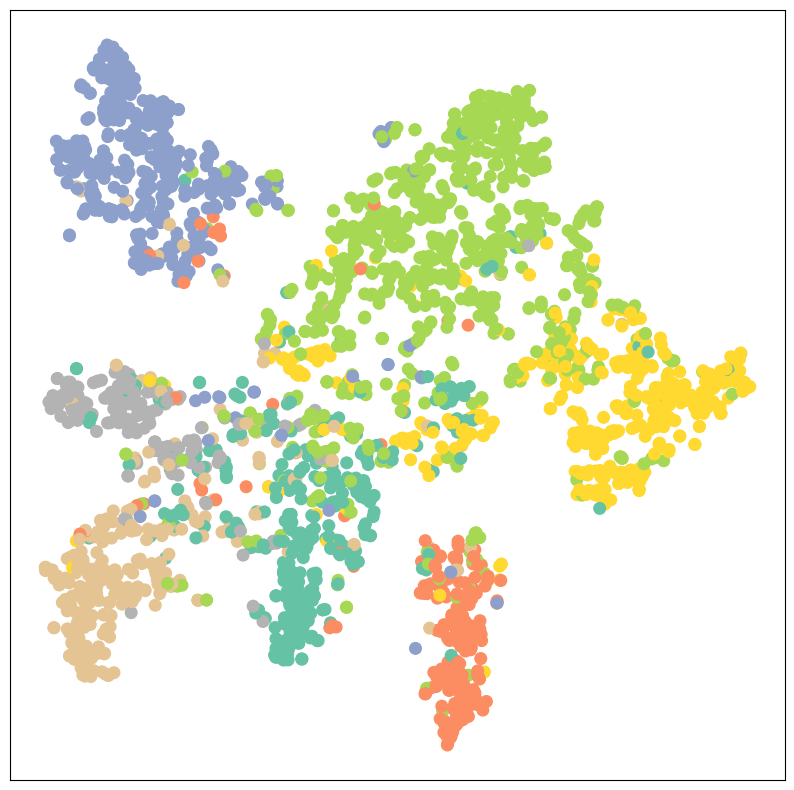

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z=TSNE(n_components=2).fit_transform (h. detach().cpu().numpy ())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:,0],z[:,1],s=70, c=color, cmap="Set2")
    plt.show()

model.eval()
out = model(data.x, data.edge_index)
visualize(out,color=data.y)

可解释性（Explainer/GNNExplainer + fidelity drop）
节点级可解释性：对某一个具体节点，模型为什么会给出当前的预测？它主要依赖了哪些邻居边、哪些输入特征？

步骤：
1、选节点（解释对象）：从测试集中挑选若干节点作为解释案例
2、生成解释（解释器）：用GNNExplainer等方法输出

    重要边/重要邻居（结构解释）

    重要特征维度（特征解释）

3、解释可视化与阅读：画出解释子图、列出top特征
4、解释质量验证（fidelity）：把解释器认为关键的边/特征移除，看预测置信度是否显著下降（证明“解释确实影响模型决策”）


1、选节点（解释对象）：从测试集中挑选若干节点作为解释案例
选“预测正确 + 预测错误”的节点各一个
A-解释“模型为什么成功”（正确样本）

选一个预测正确的测试节点来解释，目的在于：

    看模型在“正常工作”的情况下，确实在依赖哪些邻居/哪些特征

    验证解释是否符合直觉：例如解释子图主要集中在该节点的局部邻域（1~2 hop），而不是随机散边

    这类解释更容易讲清楚：模型靠什么信息做对了，说明模型的决策路径在理想情形下是什么样的

B-解释“模型为什么失败”（错误样本）

选一个预测错误的测试节点来解释，目的在于：

    定位误判的原因：

    是否因为邻居跨类别连接太多（结构混杂）

    是否因为节点特征与其他类别更相似（特征模糊）

    是否因为局部子图本身就不典型/不纯净（类间边界点）
t-SNE 看到“分簇但交叉多”，解释能给出“交叉从何而来”的机制性证据
说明模型在什么情况下会做错，以及错在哪里

In [9]:
import torch

# 1) 进入评估模式：关闭 dropout 等随机行为，让输出稳定
model.eval()

# 2) 前向传播：得到每个节点对 7 类的 logits（未归一化得分）
#    对 GCN：需要 (data.x, data.edge_index)
#    如果你用的是 MLP：这里要改成 model(data.x)
out = model(data.x, data.edge_index)  # [num_nodes, num_classes]

# 3) 取每个节点得分最高的类别作为预测类别
pred = out.argmax(dim=1)  # [num_nodes]

# 4) 找到测试集的所有节点索引
test_idx = data.test_mask.nonzero(as_tuple=False).view(-1)

# 5) 在测试集中，分别找出预测正确/预测错误的节点
correct = test_idx[pred[test_idx] == data.y[test_idx]]
wrong   = test_idx[pred[test_idx] != data.y[test_idx]]

# 6) 取一个正确的节点作为 node_ok
node_ok = int(correct[0])

# 7) 取一个错误的节点作为 node_bad（如果刚好全都预测对，就退而求其次选另一个正确节点）
node_bad = int(wrong[0]) if len(wrong) > 0 else int(correct[1])

print("node_ok :", node_ok,  "pred:", int(pred[node_ok]),  "y:", int(data.y[node_ok]))
print("node_bad:", node_bad, "pred:", int(pred[node_bad]), "y:", int(data.y[node_bad]))
print("num test nodes:", int(data.test_mask.sum()), "num wrong:", int(len(wrong)))


node_ok : 1709 pred: 2 y: 2
node_bad: 1708 pred: 1 y: 3
num test nodes: 1000 num wrong: 186


node_ok = 1709：模型把它预测为 2 类，真实也是 2 类，这是一个“预测正确”的测试节点，用来解释“模型为什么做对”。

node_bad = 1708：模型把它预测为 1 类，真实是 3 类，这是一个“预测错误”的测试节点，用来解释“模型为什么会错/哪里混淆”。

测试集 1000 个节点里错了 186 个，说明模型整体测试准确率大约是1−186/1000=0.814
与Test Accuracy: 0.8140 一致，说明model.eval()推理与测试函数是对齐的

2、：生成可解释性mask（GNNExplainer）
对节点 1709 和 1708，各生成一份解释，输出两类 mask：

edge_mask：每条边的重要性分数（哪些边/邻居最影响该节点预测）
node_mask（feature mask）：每个输入特征维度的重要性分数（哪些特征维度最关键）

In [10]:
import torch

# 1) 包装模型：确保 forward 只返回 logits
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x, edge_index):
        out = self.model(x, edge_index)
        # 如果将来你返回 (out, h)，这里自动取 out
        return out[0] if isinstance(out, (tuple, list)) else out

wrapped_model = ModelWrapper(model)
#保证解释器调用模型时只拿到 logits（输出分数）

# 2) 构建解释器
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=wrapped_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',   # 解释特征维度的重要性（对 Cora 是 1433 维）
    edge_mask_type='object',       # 解释边的重要性（对整个 edge_index 的每条边给一个重要性分数）
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',         # 你的模型输出是 logits，不是 softmax 概率
    ),
)

# 3) 对两个节点生成解释
ex_ok  = explainer(data.x, data.edge_index, index=1709)
ex_bad = explainer(data.x, data.edge_index, index=1708)

# 4) 打印解释对象，确认包含 node_mask / edge_mask
print("ex_ok has node_mask:", ex_ok.node_mask is not None, "edge_mask:", ex_ok.edge_mask is not None)
print("ex_bad has node_mask:", ex_bad.node_mask is not None, "edge_mask:", ex_bad.edge_mask is not None)

print("node_mask shape (ok):", tuple(ex_ok.node_mask.shape))
print("edge_mask shape (ok):", tuple(ex_ok.edge_mask.shape))


ex_ok has node_mask: True edge_mask: True
ex_bad has node_mask: True edge_mask: True
node_mask shape (ok): (2708, 1433)
edge_mask shape (ok): (10556,)


edge_index 一共有 10556 条边（有向边计数）。
edge_mask 长度 10556，表示：每一条边都有一个重要性分数（通常 0~1 之间，越大越重要）。

主要是需要对于节点 1709 的预测，哪些边/邻居连接是“关键证据”

图一共有 2708 个节点，每个节点有 1433 维特征。

node_mask 给的是一个 (2708, 1433) 的矩阵：
解释器为“每个节点的每一维特征”都分配了重要性分数

3、把 mask 输出成“Top 重要特征 + Top 重要边”

In [11]:
import torch

def top_features_for_node(explanation, node_idx, k=10):
    # 取目标节点自己的特征 mask: [1433]
    feat_mask = explanation.node_mask[node_idx].view(-1)
    vals, idxs = torch.topk(feat_mask, k=min(k, feat_mask.numel()))
    return idxs.cpu().tolist(), [float(v) for v in vals]

def top_edges(explanation, k=20):
    # edge_mask: [num_edges]
    em = explanation.edge_mask.view(-1)
    vals, idxs = torch.topk(em, k=min(k, em.numel()))
    return idxs.cpu().tolist(), [float(v) for v in vals]

# 1) node_ok 的 top 特征
ok_feat_dims, ok_feat_scores = top_features_for_node(ex_ok, node_idx=1709, k=10)
print("=== node_ok=1709 Top-10 feature dims ===")
print(ok_feat_dims)
print("scores:", ok_feat_scores)

# 2) node_bad 的 top 特征
bad_feat_dims, bad_feat_scores = top_features_for_node(ex_bad, node_idx=1708, k=10)
print("\n=== node_bad=1708 Top-10 feature dims ===")
print(bad_feat_dims)
print("scores:", bad_feat_scores)

# 3) 两个节点的 top 边（先打印 top-20 的边“索引位置”，下一步我们再把它们映射成具体边）
ok_edge_ids, ok_edge_scores = top_edges(ex_ok, k=20)
print("\n=== node_ok=1709 Top-20 edge indices in edge_index ===")
print(ok_edge_ids[:20])
print("scores:", ok_edge_scores[:20])

bad_edge_ids, bad_edge_scores = top_edges(ex_bad, k=20)
print("\n=== node_bad=1708 Top-20 edge indices in edge_index ===")
print(bad_edge_ids[:20])
print("scores:", bad_edge_scores[:20])


=== node_ok=1709 Top-10 feature dims ===
[403, 931, 1147, 1177, 721, 225, 536, 1429, 1070, 179]
scores: [0.8272473812103271, 0.8215799927711487, 0.8181476593017578, 0.8117392659187317, 0.8103811144828796, 0.8072218894958496, 0.7860353589057922, 0.7796396613121033, 0.7519281506538391, 0.7413151860237122]

=== node_bad=1708 Top-10 feature dims ===
[619, 203, 230, 1181, 65, 192, 1340, 7, 917, 41]
scores: [0.9222944378852844, 0.8886069059371948, 0.886993408203125, 0.8786388635635376, 0.8767484426498413, 0.8751391768455505, 0.8743591904640198, 0.8694844841957092, 0.8665443658828735, 0.8629758954048157]

=== node_ok=1709 Top-20 edge indices in edge_index ===
[7002, 6996, 6990, 7000, 6995, 6852, 6851, 9668, 6994, 6993, 6989, 6999, 5317, 9674, 9671, 6992, 6854, 9670, 9669, 9672]
scores: [0.9074141979217529, 0.905310869216919, 0.903060257434845, 0.8952972292900085, 0.8866694569587708, 0.8848833441734314, 0.8822236657142639, 0.8818676471710205, 0.8802496790885925, 0.8772836923599243, 0.876130521

Top-10 feature dims：403、931…是 Cora 的 1433 维输入特征的“维度编号”
Top-20 edge indices：7002, 6996, ...不是“节点编号”，而是 edge_index 这张表里的“第几列”


4、把重要边映射成具体边，并画解释子图


=== node 1709 top incident edges ===
00. eid= 6852  (1739 -> 1709)  w=0.8849   y[s]=2, y[t]=2
01. eid= 6851  (1738 -> 1709)  w=0.8822   y[s]=2, y[t]=2
02. eid= 6854  (2365 -> 1709)  w=0.8581   y[s]=2, y[t]=2
03. eid= 6850  (1358 -> 1709)  w=0.7778   y[s]=2, y[t]=2
04. eid= 6853  (1986 -> 1709)  w=0.1916   y[s]=3, y[t]=2
05. eid= 6991  (1709 -> 1738)  w=0.1648   y[s]=2, y[t]=2
06. eid= 9673  (1709 -> 2365)  w=0.1341   y[s]=2, y[t]=2
07. eid= 6998  (1709 -> 1739)  w=0.1285   y[s]=2, y[t]=2
08. eid= 5367  (1709 -> 1358)  w=0.1168   y[s]=2, y[t]=2
09. eid= 8167  (1709 -> 1986)  w=0.1141   y[s]=2, y[t]=3

=== node 1708 top incident edges ===
00. eid= 1925  (1708 -> 467)  w=0.9186   y[s]=3, y[t]=0
01. eid= 7558  (1708 -> 1857)  w=0.9178   y[s]=3, y[t]=3
02. eid= 9509  (1708 -> 2313)  w=0.9169   y[s]=3, y[t]=2
03. eid= 9511  (1708 -> 2314)  w=0.9156   y[s]=3, y[t]=3
04. eid= 3471  (1708 -> 873)  w=0.8972   y[s]=3, y[t]=0
05. eid= 6845  (873 -> 1708)  w=0.8866   y[s]=0, y[t]=3
06. eid= 6848  

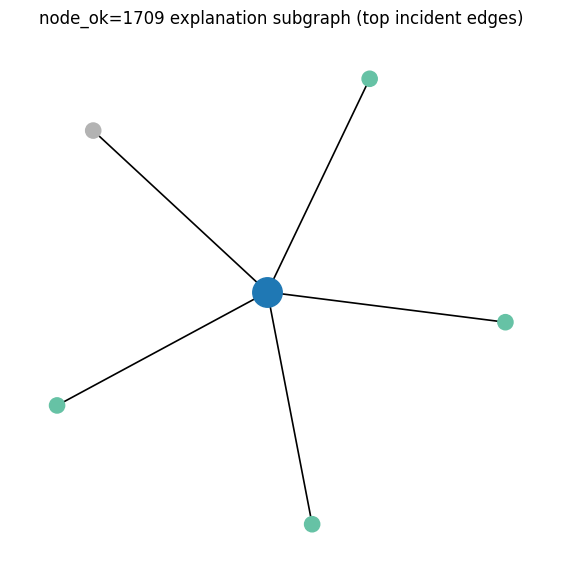

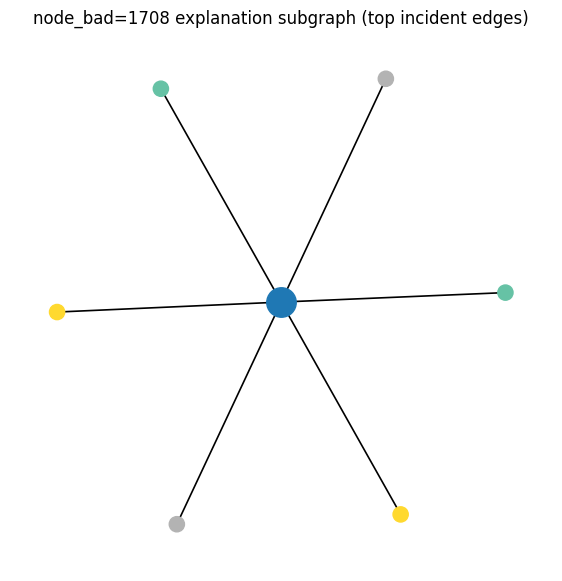

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

edge_index = data.edge_index  # [2, E]
src_all = edge_index[0]
dst_all = edge_index[1]

def top_incident_edges(explanation, node_idx, k=20):
    """只在“与 node_idx 相连”的边里取 top-k，避免全图 top 边干扰解释。"""
    edge_mask = explanation.edge_mask.view(-1)

    incident = (src_all == node_idx) | (dst_all == node_idx)  # [E] bool，只挑出“和目标节点连着的边”
    incident_eids = incident.nonzero(as_tuple=False).view(-1) # 这些是边的列索引 eid

    incident_scores = edge_mask[incident]  # 只取 incident 边对应的分数
    k = min(k, incident_scores.numel())
    top_vals, top_pos = torch.topk(incident_scores, k=k)

    top_eids = incident_eids[top_pos]  # 映射回全局 eid
    return top_eids.cpu(), top_vals.cpu()

def print_edges(node_idx, top_eids, top_vals, max_print=20):
    print(f"\n=== node {node_idx} top incident edges ===")
    for i in range(min(max_print, len(top_eids))):
        eid = int(top_eids[i])
        s = int(src_all[eid])
        t = int(dst_all[eid])
        w = float(top_vals[i])
        # 打印：边两端节点、以及两端真实类别（便于观察是否跨类连接）
        print(f"{i:02d}. eid={eid:5d}  ({s} -> {t})  w={w:.4f}   y[s]={int(data.y[s])}, y[t]={int(data.y[t])}")

def draw_explanation_star(node_idx, top_eids, title="explanation"):
    """画一个以 node_idx 为中心、由 top incident edges 构成的解释子图（最直观）。"""
    G = nx.Graph()
    # 加入 top edges
    for eid in top_eids.tolist():
        s = int(src_all[eid])
        t = int(dst_all[eid])
        G.add_edge(s, t)

    # 画图：用真实标签给节点上色
    nodes = list(G.nodes())
    colors = [int(data.y[n]) for n in nodes]

    plt.figure(figsize=(7,7))
    pos = nx.spring_layout(G, seed=42)

    # 先画普通节点
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[n for n in nodes if n != node_idx],
                           node_size=120,
                           node_color=[colors[nodes.index(n)] for n in nodes if n != node_idx],
                           cmap="Set2")
    # 再突出中心节点
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[node_idx],
                           node_size=450)

    nx.draw_networkx_edges(G, pos, width=1.2)
    plt.title(title)
    plt.axis("off")
    plt.show()

# 对 node_ok / node_bad 分别取“与其相连的 top-20 重要边”
ok_eids, ok_vals = top_incident_edges(ex_ok, node_idx=1709, k=20)
bad_eids, bad_vals = top_incident_edges(ex_bad, node_idx=1708, k=20)

# 打印“具体是哪条边”
#若多数边连接到同一类邻居，说明该节点处在“干净的同类社区”
#若大量边连到不同类邻居，错分往往更容易发生（邻域混杂）
print_edges(1709, ok_eids, ok_vals, max_print=20)
print_edges(1708, bad_eids, bad_vals, max_print=20)

# 画解释子图
#把这些关键边组成一个小子图画出来，并把中心节点加粗突出
draw_explanation_star(1709, ok_eids, title="node_ok=1709 explanation subgraph (top incident edges)")
draw_explanation_star(1708, bad_eids, title="node_bad=1708 explanation subgraph (top incident edges)")


=== node 1709 top incident edges ===
00. eid= 6852  (1739 -> 1709)  w=0.8849   y[s]=2, y[t]=2
01. eid= 6851  (1738 -> 1709)  w=0.8822   y[s]=2, y[t]=2
02. eid= 6854  (2365 -> 1709)  w=0.8581   y[s]=2, y[t]=2
03. eid= 6850  (1358 -> 1709)  w=0.7778   y[s]=2, y[t]=2
说明：解释器认为最关键的证据基本都来自“同类别（2类）邻居”

=== node 1708 top incident edges ===
00. eid= 1925  (1708 -> 467)  w=0.9186   y[s]=3, y[t]=0
02. eid= 9509  (1708 -> 2313)  w=0.9169   y[s]=3, y[t]=2
04. eid= 3471  (1708 -> 873)  w=0.8972   y[s]=3, y[t]=0
说明：1708 的邻域不是“纯 3 类社区”，而是 0 / 2 / 3 混在一起，并且“跨类边”的权重很高

第一个图：周围小点大多是同一种颜色（同类邻居占主导）
第二个图：周围小点颜色明显更多、更杂

In [13]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def logits_on_edge_index(edge_index_new):
    model.eval()
    out = model(data.x, edge_index_new)
    return out[0] if isinstance(out, (tuple, list)) else out

@torch.no_grad()
def fidelity_remove_topk_edges(node_idx, top_eids, k=4):
    """
    删除 top_eids 中前 k 条边（最重要的 k 条），观察预测变化。
    返回：原预测类别/置信度、删边后原预测类别置信度、删边后新预测类别/置信度。
    """
    # 原图输出
    logits0 = logits_on_edge_index(data.edge_index)
    prob0 = F.softmax(logits0, dim=1)
    pred0 = int(prob0[node_idx].argmax())
    conf0 = float(prob0[node_idx, pred0])
    true = int(data.y[node_idx])

    # 删边：从 edge_index 中移除这些 eid
    E = data.edge_index.size(1)
    keep = torch.ones(E, dtype=torch.bool, device=data.edge_index.device)

    k = min(k, len(top_eids))
    remove_eids = top_eids[:k].to(keep.device)
    keep[remove_eids] = False
    edge_index_new = data.edge_index[:, keep]

    # 删边后的输出
    logits1 = logits_on_edge_index(edge_index_new)
    prob1 = F.softmax(logits1, dim=1)
    pred1 = int(prob1[node_idx].argmax())
    conf1_pred0 = float(prob1[node_idx, pred0])  # 原预测类的概率（看掉多少）
    conf1 = float(prob1[node_idx, pred1])

    return {
        "node": node_idx,
        "true": true,
        "pred_before": pred0,
        "conf_before": conf0,
        "conf_after_on_pred_before": conf1_pred0,
        "drop": conf0 - conf1_pred0,
        "pred_after": pred1,
        "conf_after": conf1,
        "removed_edges": k,
        "edges_before": int(E),
        "edges_after": int(edge_index_new.size(1)),
    }

# 先从小 k 开始：4、8、12 做对比
for k in [4, 8, 12]:
    print(f"\n--- k={k} ---")
    print("OK 1709:", fidelity_remove_topk_edges(1709, ok_eids, k=k))
    print("BAD1708:", fidelity_remove_topk_edges(1708, bad_eids, k=k))



--- k=4 ---
OK 1709: {'node': 1709, 'true': 2, 'pred_before': 2, 'conf_before': 0.8195142149925232, 'conf_after_on_pred_before': 0.16493351757526398, 'drop': 0.6545806974172592, 'pred_after': 3, 'conf_after': 0.40997686982154846, 'removed_edges': 4, 'edges_before': 10556, 'edges_after': 10552}
BAD1708: {'node': 1708, 'true': 3, 'pred_before': 1, 'conf_before': 0.20795901119709015, 'conf_after_on_pred_before': 0.2527996003627777, 'drop': -0.04484058916568756, 'pred_after': 1, 'conf_after': 0.2527996003627777, 'removed_edges': 4, 'edges_before': 10556, 'edges_after': 10552}

--- k=8 ---
OK 1709: {'node': 1709, 'true': 2, 'pred_before': 2, 'conf_before': 0.8195142149925232, 'conf_after_on_pred_before': 0.10534225404262543, 'drop': 0.7141719609498978, 'pred_after': 3, 'conf_after': 0.2789016664028168, 'removed_edges': 8, 'edges_before': 10556, 'edges_after': 10548}
BAD1708: {'node': 1708, 'true': 3, 'pred_before': 1, 'conf_before': 0.20795901119709015, 'conf_after_on_pred_before': 0.18945

node_ok=1709 的解释：高度 faithful（删关键边→预测崩）

原始：
    真值 y=2，预测 pred_before=2
    对类 2 的置信度 conf_before=0.8195
删掉 top-4 关键边后：
    原预测类 2 的置信度掉到 0.1649 conf_after_on_pred_before
    下降 drop = 0.6546
    预测类别直接从 2 变成 3（pred_after=3）
删到更多（k=8）后：
    原预测类 2 置信度进一步掉到 0.1053 conf_after_on_pred_before
    下降 drop =0.7142
    仍然预测成 3


对节点 1709 来说，解释器选出的那几条“关键邻居连接”几乎是模型判断为 2 类的主要证据；一旦删掉这些边，模型马上失去关键结构信息，预测从 2 翻到 3，说明这份解释对模型决策是高度忠实的。

node_bad=1708 的解释

原始：
    真值 y=3，但预测 pred_before=1
    预测为 1 的置信度只有 conf_before=0.2080
k=4 的现象：删边后反而更像 1（drop 负数）
    conf_after_on_pred_before=0.2528
    drop=-0.0448（置信度反而上升）
    这通常说明：你删掉的那 4 条边不一定是“支持预测为 1”的证据，可能删掉的是对 1 有抑制作用、或对其他类有支持作用的边，导致模型更偏向 1。
k=8：轻微下降，但仍预测 1
    conf_after_on_pred_before=0.2079
    drop=0.0185，仍然 pred_after=1
    说明删 8 条还不足以改变决策。
k=12：预测翻转到正确类 3（最关键）
    原预测类 1 的置信度下降到 0.1329（drop 0.0751）
    pred_after 从 1 变成 3
    新预测（类 3）的置信度 conf_after=0.3000


对节点 1708，模型本身对“预测为 1”并不自信（0.208）。当移除更多解释器认为重要的邻域连接（到 k≈12）后，预测从 1 翻转为真实类别 3，说明这些关键边里包含了会把节点表示“拉离真实 3 类”的结构因素。也就是说，1708 的误判与其关键邻域中混杂/跨类连接有关，而不是单一特征造成。

Fidelity 验证显示：对正确分类节点 1709（y=2），移除解释器选出的 top-4 关键邻域边后，原预测类 2 的置信度从 0.820 急剧下降至 0.165（drop=0.655），且预测由 2 翻转为 3，表明该解释对模型决策高度忠实。
对误分类节点 1708（y=3，pred=1），小幅移除（k=4）未削弱原预测，说明局部边的重要性存在非单调效应；当移除更多关键边（k≈12）后，预测从 1 翻转为真实类别 3（conf≈0.300），提示误判与关键邻域中跨类连接/邻域混杂造成的表示偏移有关。

对照组1：只保留 top-k 边

In [14]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def logits_on_edge_index(edge_index_new):
    model.eval()
    out = model(data.x, edge_index_new)
    return out[0] if isinstance(out, (tuple, list)) else out

@torch.no_grad()
def insertion_keep_topk_edges(node_idx, top_eids, k=4):
    """
    只保留 top_eids 中前 k 条边（其余边全部删除），观察节点预测变化。
    注意：这是“全图删边”，但只保留少量边，图会非常稀疏。
    """
    # 原图输出
    logits0 = logits_on_edge_index(data.edge_index)
    prob0 = F.softmax(logits0, dim=1)
    pred0 = int(prob0[node_idx].argmax())
    conf0 = float(prob0[node_idx, pred0])
    true = int(data.y[node_idx])

    # 只保留 top-k 边
    E = data.edge_index.size(1)
    keep = torch.zeros(E, dtype=torch.bool, device=data.edge_index.device)

    k = min(k, len(top_eids))
    keep_eids = top_eids[:k].to(keep.device)
    keep[keep_eids] = True
    edge_index_new = data.edge_index[:, keep]

    # 保留后输出
    logits1 = logits_on_edge_index(edge_index_new)
    prob1 = F.softmax(logits1, dim=1)
    pred1 = int(prob1[node_idx].argmax())
    conf1 = float(prob1[node_idx, pred1])
    conf1_on_pred0 = float(prob1[node_idx, pred0])  # 原预测类在“只保留边”后的概率

    return {
        "node": node_idx,
        "true": true,
        "pred_before": pred0,
        "conf_before": conf0,
        "pred_after": pred1,
        "conf_after": conf1,
        "conf_after_on_pred_before": conf1_on_pred0,
        "drop_on_pred_before": conf0 - conf1_on_pred0,
        "kept_edges": k,
        "edges_before": int(E),
        "edges_after": int(edge_index_new.size(1)),
    }

# 跑一组 k，建议从小到大看趋势
ks = [2, 4, 6, 8, 10, 12]

print("=== Insertion Fidelity: keep only top-k incident edges ===")
for k in ks:
    print(f"\n--- k={k} ---")
    print("OK 1709:", insertion_keep_topk_edges(1709, ok_eids, k=k))
    print("BAD1708:", insertion_keep_topk_edges(1708, bad_eids, k=k))


=== Insertion Fidelity: keep only top-k incident edges ===

--- k=2 ---
OK 1709: {'node': 1709, 'true': 2, 'pred_before': 2, 'conf_before': 0.8195142149925232, 'pred_after': 2, 'conf_after': 0.9737836718559265, 'conf_after_on_pred_before': 0.9737836718559265, 'drop_on_pred_before': -0.15426945686340332, 'kept_edges': 2, 'edges_before': 10556, 'edges_after': 2}
BAD1708: {'node': 1708, 'true': 3, 'pred_before': 1, 'conf_before': 0.20795901119709015, 'pred_after': 3, 'conf_after': 0.3000487983226776, 'conf_after_on_pred_before': 0.13287769258022308, 'drop_on_pred_before': 0.07508131861686707, 'kept_edges': 2, 'edges_before': 10556, 'edges_after': 2}

--- k=4 ---
OK 1709: {'node': 1709, 'true': 2, 'pred_before': 2, 'conf_before': 0.8195142149925232, 'pred_after': 2, 'conf_after': 0.9996132254600525, 'conf_after_on_pred_before': 0.9996132254600525, 'drop_on_pred_before': -0.1800990104675293, 'kept_edges': 4, 'edges_before': 10556, 'edges_after': 4}
BAD1708: {'node': 1708, 'true': 3, 'pred_b

node_ok=1709：解释非常强

Deletion：删 top-4 关键边就让预测从 2 翻到 3，置信度大幅下降（drop≈0.65+）
Insertion：只保留 top-2 / top-4 边，预测仍是 2，而且置信度甚至接近 1


对 1709 来说，这些关键边既是“必要的”（删掉就不行），也是“近乎充分的”（只保留也行），解释高度 faithful。
验证了之前论文中的Plausibility(合理性)和Fidelity(保真度)

node_bad=1708：局部证据很不稳定（这正是错分节点的典型特征）

Deletion：删到 k=12 才把预测从 1 翻到真实类 3
Insertion：只保留少量边时，预测会在 3、0、5 之间跳（k=2/4 是 3，k=6 是 0，k=8 是 5…）


1708 本身处在“结构/特征混杂”的区域，模型决策边界不稳，所以“只靠少量边”时预测更容易漂移。
你的 insertion 实验因为“全图只剩几条边”，导致归一化与消息传递环境剧烈改变，所以预测更容易异常跳变。

对照组2：只在“目标节点的 k-hop 局部子图”里做保留
先抽出 node 的 2-hop 子图（GCN 两层主要依赖 2-hop 邻域），再在这个子图里“只保留 top-k 解释边”。
这样不会把全图删成几条边，结果更稳、更可信，因为每个节点的新表示 = 自己 + 邻居的加权平均（权重与度数有关）
如果只删除到只剩几条边时：

节点度数（degree）几乎全部变成 0 或 1
归一化权重会剧烈变化
绝大多数节点完全没有邻居信息了
整个图的“传播环境”跟训练时完全不一样

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.utils import k_hop_subgraph

@torch.no_grad()
def logits_on_edge_index(edge_index_new):
    model.eval()
    out = model(data.x, edge_index_new)
    return out[0] if isinstance(out, (tuple, list)) else out

@torch.no_grad()
def insertion_on_local_subgraph(node_idx, top_eids, k_keep=4, num_hops=2):
    """
    规范 insertion：
    1) 先取 node_idx 的 num_hops-hop 局部子图（在原图的 edge_index 上抽）
    2) 在“这个局部子图对应的原图边集合”里，只保留 top_eids 的前 k_keep 条
    """
    # 原图预测
    logits0 = logits_on_edge_index(data.edge_index)
    prob0 = F.softmax(logits0, dim=1)
    pred0 = int(prob0[node_idx].argmax())
    conf0 = float(prob0[node_idx, pred0])
    true = int(data.y[node_idx])

    # 取 k-hop 子图（返回：子图节点集合、子图边、以及这些边在原图里的 eid 映射）
    subset, edge_index_sub, mapping, edge_mask = k_hop_subgraph(
        node_idx=node_idx,
        num_hops=num_hops,
        edge_index=data.edge_index,
        relabel_nodes=False,   # 保持原节点编号，避免你理解混乱
        num_nodes=data.num_nodes
    )
    # edge_mask 是 bool [E]，表示哪些原图边属于该子图
    sub_eids = edge_mask.nonzero(as_tuple=False).view(-1)  # 原图 eid 列表

    # 在子图边里做“只保留 top-k”
    keep = torch.zeros(data.edge_index.size(1), dtype=torch.bool, device=data.edge_index.device)
    # 只允许保留属于子图的边
    keep[sub_eids.to(keep.device)] = True
    # 再把子图里非 top-k 的边去掉：只保留 top_eids 前 k_keep
    k_keep = min(k_keep, len(top_eids))
    allowed = torch.zeros_like(keep)
    allowed[top_eids[:k_keep].to(allowed.device)] = True
    keep = keep & allowed

    edge_index_new = data.edge_index[:, keep]

    # 新图预测
    logits1 = logits_on_edge_index(edge_index_new)
    prob1 = F.softmax(logits1, dim=1)
    pred1 = int(prob1[node_idx].argmax())
    conf1 = float(prob1[node_idx, pred1])
    conf1_on_pred0 = float(prob1[node_idx, pred0])

    return {
        "node": node_idx,
        "true": true,
        "pred_before": pred0,
        "conf_before": conf0,
        "pred_after": pred1,
        "conf_after": conf1,
        "conf_after_on_pred_before": conf1_on_pred0,
        "drop_on_pred_before": conf0 - conf1_on_pred0,
        "kept_edges": int(k_keep),
        "edges_after": int(edge_index_new.size(1)),
        "subgraph_edges_available": int(sub_eids.numel()),
    }

for k_keep in [2, 4, 8, 12]:
    print("\n--- local insertion k_keep =", k_keep, "---")
    print("OK 1709:", insertion_on_local_subgraph(1709, ok_eids, k_keep=k_keep, num_hops=2))
    print("BAD1708:", insertion_on_local_subgraph(1708, bad_eids, k_keep=k_keep, num_hops=2))



--- local insertion k_keep = 2 ---
OK 1709: {'node': 1709, 'true': 2, 'pred_before': 2, 'conf_before': 0.8195142149925232, 'pred_after': 2, 'conf_after': 0.9737836718559265, 'conf_after_on_pred_before': 0.9737836718559265, 'drop_on_pred_before': -0.15426945686340332, 'kept_edges': 2, 'edges_after': 2, 'subgraph_edges_available': 868}
BAD1708: {'node': 1708, 'true': 3, 'pred_before': 1, 'conf_before': 0.20795901119709015, 'pred_after': 3, 'conf_after': 0.3000487983226776, 'conf_after_on_pred_before': 0.13287769258022308, 'drop_on_pred_before': 0.07508131861686707, 'kept_edges': 2, 'edges_after': 2, 'subgraph_edges_available': 692}

--- local insertion k_keep = 4 ---
OK 1709: {'node': 1709, 'true': 2, 'pred_before': 2, 'conf_before': 0.8195142149925232, 'pred_after': 2, 'conf_after': 0.9996132254600525, 'conf_after_on_pred_before': 0.9996132254600525, 'drop_on_pred_before': -0.1800990104675293, 'kept_edges': 4, 'edges_after': 4, 'subgraph_edges_available': 868}
BAD1708: {'node': 1708, '

1709：subgraph_edges_available: 868
1708：subgraph_edges_available: 692
目标节点 2-hop 邻域内，其实原本有几百条边，这才是两层 GCN 真正能“接触到”的结构环境。

node_ok=1709：
原图：预测 2，conf_before=0.8195
只保留 top-2：仍预测 2，conf_after=0.9738
只保留 top-4：仍预测 2，conf_after=0.9996
只保留 top-8：仍预测 2，conf_after=0.9632
只保留 top-10：仍预测 2，conf_after=0.9286

对 1709 来说，解释器找出的关键边不仅“重要”，甚至对模型而言接近“充分证据”：只要这些边存在，模型就能非常自信地给出类别 2。
1709 的解释边同时满足“必要性（deletion）”与“近似充分性（insertion）

node_bad=1708：解释显示“证据混杂”，并且少量关键边可能是误判来源

原图：预测 1（错），conf_before=0.208
只保留 top-2 / top-4：预测变成 3（对），conf_after=0.3000，在最关键的少数连接上，模型其实能倾向真实类 3
只保留 top-8：预测变成 5（错）
只保留 top-12：预测变成 0（错）

对 1708，解释器挑出来的“重要边”并不是同一种作用：
有的边把它推向真实类 3，有的边把它推向其他类（0/5/1）。
“证据冲突 / 邻域混杂”：节点周围存在跨类连接，模型在不同边子集下会被不同社群拉扯。

1708 的误分类与其关键邻域存在跨类连接/混杂证据有关；少量核心边可支持正确类 3，但随着更多高权重边加入，表示被不同类别邻域拉扯，导致预测不稳定并偏离真实类别。

节点级解释：
选对/错节点（1709 vs 1708）
解释器输出 node_mask、edge_mask
deletion fidelity：删关键边是否破坏预测
insertion fidelity：只保留关键边是否还能支撑预测
通过对比解释“为何对节点稳定、错节点混杂”